# Exercise 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, chi2, expon, pareto

## Discussion w/ Jason before lecture

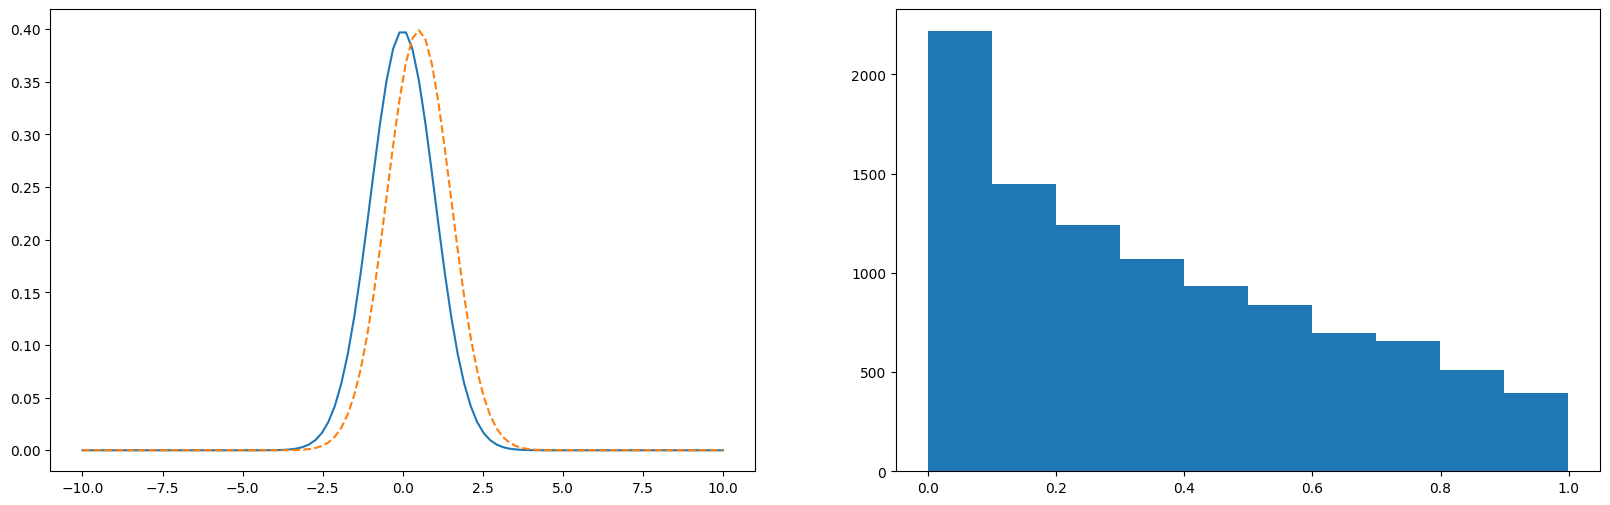

In [3]:
xs = np.linspace(-10, 10, 100)

loc1 = 0
loc2 = 0.5

dist1 = norm.pdf(xs, loc=loc1)
dist2 = norm.pdf(xs, loc=loc2)

dist2_samples = norm.rvs(size=10_000, loc=loc2)
p_vals = 1 - norm.cdf(dist2_samples, loc=loc1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(xs, dist1)
ax1.plot(xs, dist2, linestyle="--")

ax2.hist(p_vals);

(array([6.079e+03, 2.345e+03, 9.320e+02, 4.040e+02, 1.420e+02, 5.400e+01,
        3.100e+01, 5.000e+00, 5.000e+00, 3.000e+00]),
 array([ 1. ,  9.9, 18.8, 27.7, 36.6, 45.5, 54.4, 63.3, 72.2, 81.1, 90. ]),
 <BarContainer object of 10 artists>)

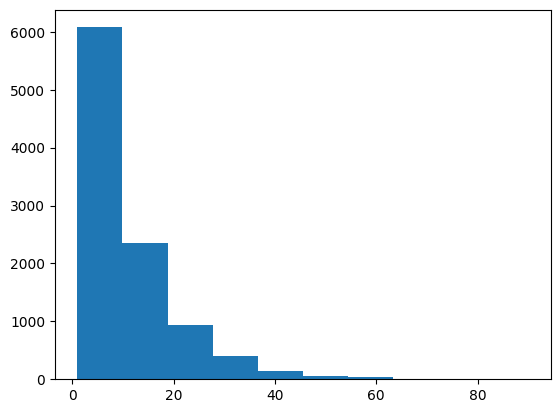

In [4]:
def geometric(n, p):
    us = uniform.rvs(size=n)
    return np.floor(np.log(us) / np.log(1 - p)) + 1

gs = geometric(10_000, 0.1)

plt.hist(gs)

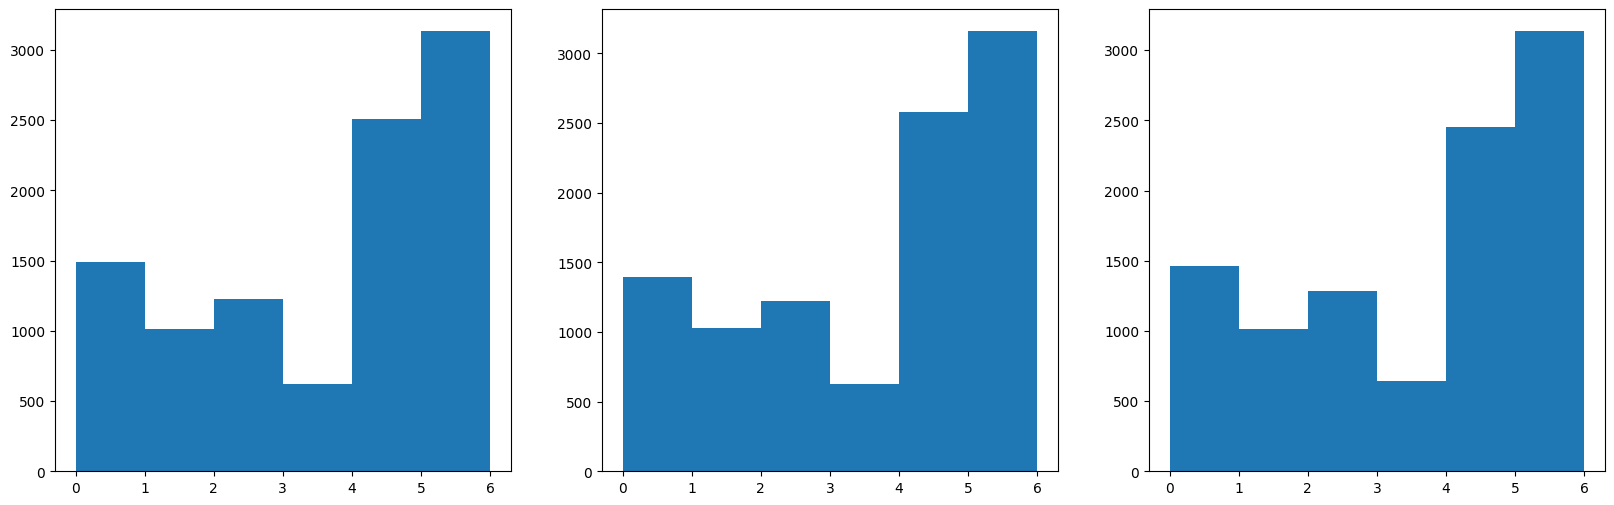

P-val (crude)    : 0.8568132611957631
P-val (rejection): 0.2510550962263116
P-val (alias)    : 0.7200530948697232


In [5]:
def discrete_crude(n, p):
    # not exactly the same crude method as in the slides, but definitely crude
    us = uniform.rvs(size=n)

    vals = np.zeros_like(us)
    thresh = p[0]

    for p_i in p[1:]:
        vals += thresh < us
        thresh += p_i

    return vals

def discrete_rejection(n, p):
    c = np.max(p)
    k = len(p)

    vals = np.empty(n)
    for j in range(n):
        while True:
            i = int(np.floor(k * uniform.rvs())) # int may just round down on its own, but better safe than sorry
            if uniform.rvs() <= p[i] / c:
                vals[j] = i
                break

    return vals

def generate_f_and_l(p):
    k = len(p)
    L = np.arange(k)
    F = p * k
    G = np.where(F >= 1)[0]
    S = np.where(F <= 1)[0]

    while S.size:
        i = G[0]
        j = S[0]
        L[j] = i
        F[i] = F[i] - (1 - F[j])
        if F[i] < 1 - 1e-8:
            G = G[1:]
            S = np.append(S, np.array([i]))
        S = S[1:]

    return F, L

def discrete_alias(n, f, l):
    k = len(f)
    
    vals = np.empty(n)
    for j in range(n):
        i = int(np.floor(k * uniform.rvs()))
        if uniform.rvs() <= f[i]:
            vals[j] = i
        else:
            vals[j] = l[i]

    return vals

ps = np.array([7/48, 5/48, 1/8, 1/16, 1/4, 5/16])

crude_vals = discrete_crude(10_000, ps)
rejection_vals = discrete_rejection(10_000, ps)

fs, ls = generate_f_and_l(ps)
alias_vals = discrete_alias(10_000, fs, ls)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.hist(crude_vals, bins=np.arange(7))
ax2.hist(rejection_vals, bins=np.arange(7))
ax3.hist(alias_vals, bins=np.arange(7))

plt.show()


def chi2_test(samples, ps):

    _, n = np.unique(samples, return_counts=True)

    n_exp = ps * np.sum(n)

    T = np.sum((n - n_exp)** 2 / n_exp)

    # test stat follows chi2(k - 1), week 1 slide 10
    return 1 - chi2.cdf(T, len(ps) - 1)

print("P-val (crude)    :", chi2_test(crude_vals, ps))
print("P-val (rejection):", chi2_test(rejection_vals, ps))
print("P-val (alias)    :", chi2_test(alias_vals, ps))

## Exercise 3

2.0001215722230357


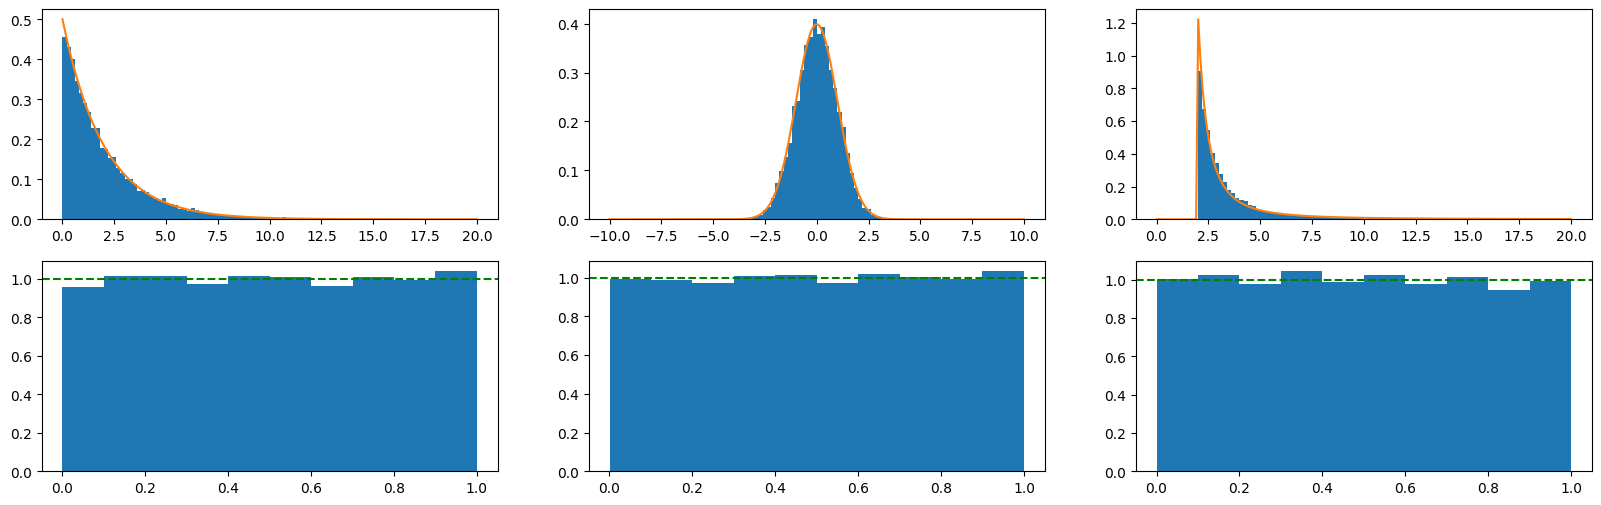

In [ ]:
def sample_exponential(n, gamma):
    us = uniform.rvs(size=n)
    return -np.log(us) / gamma

def sample_normal(n, mu=0, sigma=1):
    n_even = int(np.ceil(n / 2)) * 2
    us = uniform.rvs(size=n_even).reshape(2, -1)

    r = np.sqrt(-2 * np.log(us[0]))
    theta = 2 * np.pi * us[1]

    return np.vstack([r * np.cos(theta), r * np.sin(theta)]).reshape(-1)

def sample_pareto(n, k, beta):
    us = uniform.rvs(size=n)
    return beta * us ** (-1/k)


gamma = 0.5

mu = 0
sigma = 1

beta = 2
k = 2.05

expon_dist = expon(scale=1/gamma)
norm_dist = norm(loc=mu, scale=sigma)
pareto_dist = pareto(b=k - 0.8, loc=beta - 1)

exponentials = sample_exponential(10_000, gamma)
normals = sample_normal(10_000, mu, sigma)
paretos = sample_pareto(10_000, k, beta)

expon_p_vals = expon_dist.cdf(exponentials)
norm_p_vals = norm_dist.cdf(normals)
pareto_p_vals = 1 - (beta / paretos)**k#pareto_dist.cdf(paretos)

xs = np.linspace(-10, 10, 200)
xs_pos = np.linspace(0, 20, 200)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 6))

hist_params = {
    "density": True,
    "range": (-10, 10),
    "bins": 100,
}

hist_params_pos = {
    "density": True,
    "range": (0, 20),
    "bins": 100,
}

ax1.hist(exponentials, **hist_params_pos)
ax1.plot(xs_pos, expon_dist.pdf(xs_pos))
ax2.hist(normals, **hist_params)
ax2.plot(xs, norm_dist.pdf(xs))
ax3.hist(paretos, **hist_params_pos)
ax3.plot(xs_pos, pareto_dist.pdf(xs_pos))

ax4.hist(expon_p_vals, density=True)
ax4.axhline(1, linestyle="--", color="g")
ax5.hist(norm_p_vals, density=True)
ax5.axhline(1, linestyle="--", color="g")
ax6.hist(pareto_p_vals, density=True)
ax6.axhline(1, linestyle="--", color="g")

print(min(paretos))
pass;